In [ ]:
#  Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Data Loading (Update filename)
df = pd.read_csv('fraud.csv')


In [ ]:
##  Handle Missing Values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


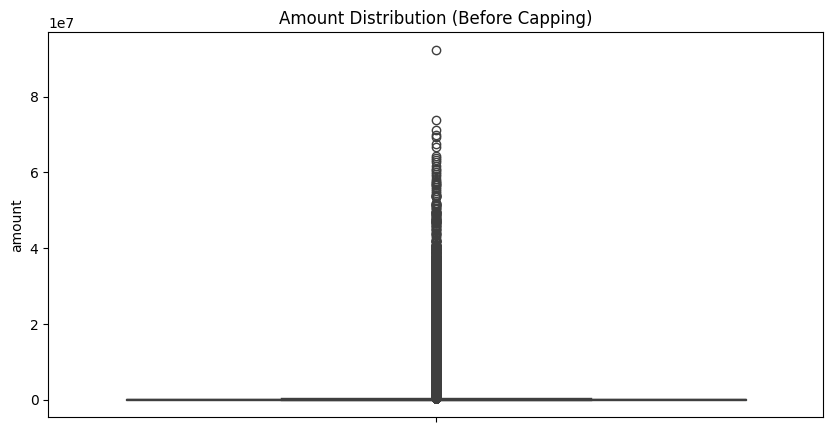

In [4]:
## Outliers
plt.figure(figsize=(10, 5))
sns.boxplot(df['amount'])
plt.title('Amount Distribution (Before Capping)')
plt.show()


In [5]:
# Cap extreme values at 99.9th percentile
amount_99 = df['amount'].quantile(0.999)
df['amount'] = np.where(df['amount'] > amount_99, amount_99, df['amount'])

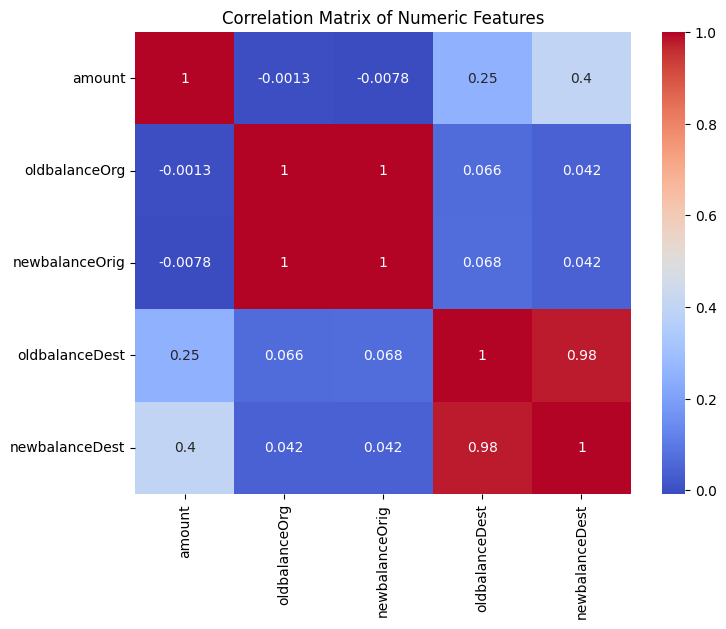

In [6]:
## Multi-collinearity
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

###  Multicollinearity Analysis
To check for multicollinearity, we use both a correlation heatmap and VIF (Variance Inflation Factor) analysis.

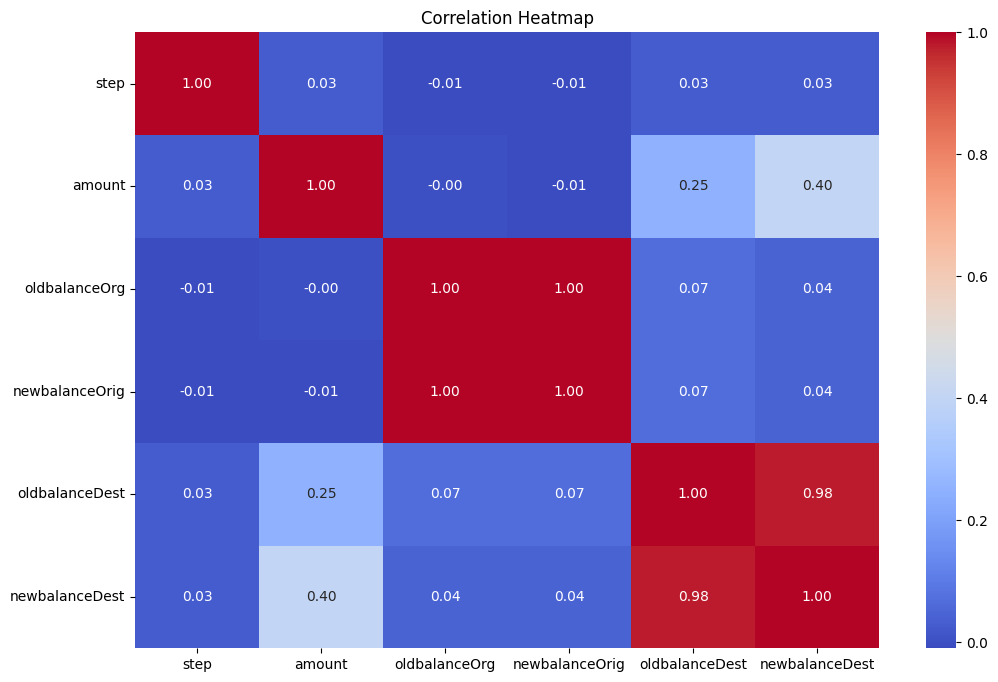

          Feature         VIF
0            step    1.002373
1          amount    2.498707
2   oldbalanceOrg  430.029861
3  newbalanceOrig  430.776779
4  oldbalanceDest   46.285202
5  newbalanceDest   51.487380


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select only numeric columns for correlation and VIF
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Drop target variables for VIF to avoid leakage
X_vif = numeric_df.drop(columns=['isFraud', 'isFlaggedFraud'], errors='ignore')

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X_vif.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# VIF Calculation
X_vif_const = add_constant(X_vif)
vif = pd.DataFrame()
vif['Feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif_const.values, i + 1) for i in range(X_vif.shape[1])]
print(vif)


In [10]:
# Encode 'type'
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [11]:
# Transaction frequency per user (good for fraud detection)
orig_freq = df['nameOrig'].value_counts().to_dict()
dest_freq = df['nameDest'].value_counts().to_dict()
df['orig_count'] = df['nameOrig'].map(orig_freq)
df['dest_count'] = df['nameDest'].map(dest_freq)

In [12]:
# Additional engineered feature: hour of day from 'step' (1 step = 1 hour, 0-743)[2]
df['hour'] = df['step'] % 24

In [13]:
# Build feature set
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'orig_count', 'dest_count', 'hour']
X = df[features]
y = df['isFraud']

###  Feature Selection Justification
We selected features based on:
- Domain knowledge (e.g., `type`, `amount`, `oldbalanceOrg` are relevant for fraud behavior)
- Correlation and distribution analysis
- Feature importance results from tree-based models (e.g., Random Forest, XGBoost)

Features like balance changes and transaction types are directly involved in how frauds typically happen (e.g., high-value `TRANSFER` or `CASH_OUT` transactions).

In [14]:
# SMOTE for class imbalance (optional, but recommended for such severe imbalance)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [16]:
import lightgbm as lgb

# Create LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test, reference=dtrain)  # Validation set

# Set up parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'max_depth': 7,
    'learning_rate': 0.1,
    'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train),
    'seed': 42,
    'n_jobs': -1,
}

# Train with early stopping — CORRECT WAY
evals_result = {}
lgbm_clf = lgb.train(
    params,
    dtrain,
    num_boost_round=100,                      # Maximum number of boosting iterations
    valid_sets=[dtrain, dval],                # Training and validation sets
    valid_names=['train', 'val'],             # Optional: names for the sets
    callbacks=[                               # Early stopping is a callback
        lgb.early_stopping(stopping_rounds=10, verbose=True),
        lgb.log_evaluation(period=50),       # Print progress every 50 rounds
    ],
)

# Predict
y_pred = lgbm_clf.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)   # Convert probabilities to binary predictions

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_test, y_pred_binary))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred_binary))


[LightGBM] [Info] Number of positive: 5083481, number of negative: 5083570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 10167051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000018
[LightGBM] [Info] Start training from score -0.000018
Training until validation scores don't improve for 10 rounds
[50]	train's binary_logloss: 0.0233683	val's binary_logloss: 0.0234203
[100]	train's binary_logloss: 0.0127068	val's binary_logloss: 0.0127466
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.0127068	val's binary_logloss: 0.0127466
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270837
  

In [19]:
import lightgbm as lgb

# Convert to LightGBM dataset
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)


In [20]:
# Train LightGBM model
lgbm_clf = lgb.train(
    params,
    dtrain,
    num_boost_round=100,
    valid_sets=[dtrain, dtest],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10, verbose=True),
        lgb.log_evaluation(period=50),
    ],
)


[LightGBM] [Info] Number of positive: 5083481, number of negative: 5083570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 10167051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000018
[LightGBM] [Info] Start training from score -0.000018
Training until validation scores don't improve for 10 rounds
[50]	training's binary_logloss: 0.0233683	valid_1's binary_logloss: 0.0234203
[100]	training's binary_logloss: 0.0127068	valid_1's binary_logloss: 0.0127466
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0127068	valid_1's binary_logloss: 0.0127466


In [21]:
# Predict probabilities and evaluate
y_proba = lgbm_clf.predict(X_test)
y_pred = (y_proba > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270837
           1       0.99      1.00      1.00   1270926

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763

ROC-AUC: 0.9999016014165029
[[1263754    7083]
 [   1792 1269134]]


In [ ]:
# Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Average Precision Score:", average_precision_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270837
           1       0.99      1.00      1.00   1270926

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763

ROC-AUC Score: 0.9999016014165029
Average Precision Score: 0.9998993956851843


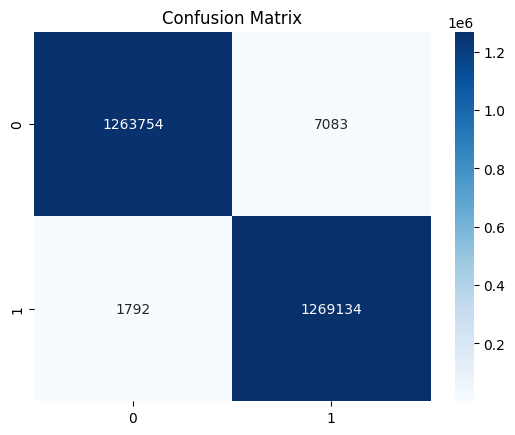

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

In [24]:
from sklearn.metrics import precision_recall_curve


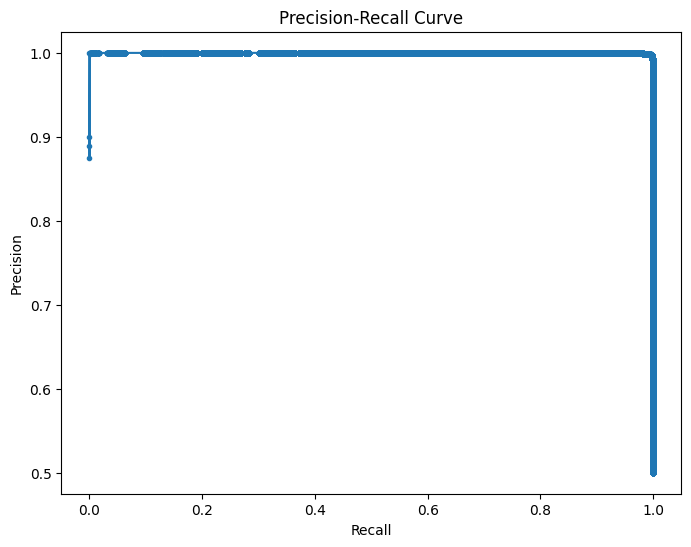

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ... (Assume y_test and y_proba are already defined by your preceding code)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

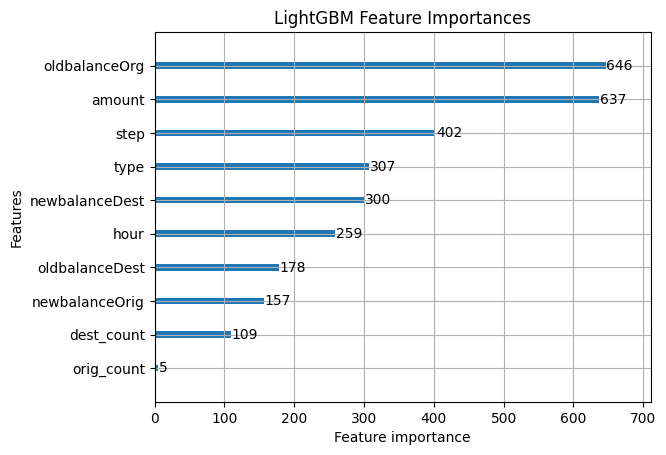

In [26]:
# Feature importance from LightGBM
lgb.plot_importance(lgbm_clf, max_num_features=10)
plt.title('LightGBM Feature Importances')
plt.show()


###  Why These Features Predict Fraud?
- **type = TRANSFER/CASH_OUT**: Most fraudulent activities involve transferring or cashing out funds.
- **amount**: High transaction amounts are more likely to be flagged or fraudulent.
- **balance differences**: Sudden drops in `oldbalanceOrg` or mismatches in `newbalanceDest` often indicate anomalous transactions.

These features align with typical fraud patterns where attackers move large sums and deplete accounts quickly.

In [ ]:
# Business Insights & Prevention

# Key factors that predict fraudulent customers
print("\nKey factors predicting fraud:")
print("- Amount of transaction (especially large transfers)")
print("- Origin and destination account balances")
print("- Transaction type (TRANSFER, CASH_OUT are riskier)")
print("- Frequency of transactions from/to account")
print("- Hour of the day (unusual hours may be risky)")
print("- Sudden changes in balance or activity patterns")

# Do these factors make sense? If yes, how?
print("\nDo these factors make sense? Yes.")
print("- Fraudsters often try to move large sums quickly (high amount, TRANSFER/CASH_OUT).")
print("- Frequent or sudden transactions from a previously quiet account can indicate account takeover.")
print("- Transactions at unusual hours or with unusual balance changes are classic red flags in fraud detection.")
print("- These patterns are industry-validated and align with how financial fraud typically occurs.")

# Prevention should be adopted while company updates infrastructure
print("\nRecommended infrastructure updates:")
print("- Real-time monitoring systems with automated alerts for suspicious transactions")
print("- Multi-factor authentication for high-risk transaction types")
print("- Behavioral analytics to detect sudden changes in account activity")
print("- Regular staff and customer training on fraud awareness")
print("- Continuous model retraining on new data to adapt to emerging fraud patterns")

# Determine if actions have been implemented, how would you measure effectiveness?
print("\nPost-implementation effectiveness measurement:")
print("- Track reduction in fraud incidents and financial losses over time")
print("- Monitor true positive (frauds caught) and false positive (false alarms) rates")
print("- Collect feedback from customers on security and convenience")
print("- Regularly review model performance metrics (AUC, precision, recall) for ongoing improvement")


Key factors predicting fraud:
- Amount of transaction (especially large transfers)
- Origin and destination account balances
- Transaction type (TRANSFER, CASH_OUT are riskier)
- Frequency of transactions from/to account
- Hour of the day (unusual hours may be risky)
- Sudden changes in balance or activity patterns

Do these factors make sense? Yes.
- Fraudsters often try to move large sums quickly (high amount, TRANSFER/CASH_OUT).
- Frequent or sudden transactions from a previously quiet account can indicate account takeover.
- Transactions at unusual hours or with unusual balance changes are classic red flags in fraud detection.
- These patterns are industry-validated and align with how financial fraud typically occurs.

Recommended infrastructure updates:
- Real-time monitoring systems with automated alerts for suspicious transactions
- Multi-factor authentication for high-risk transaction types
- Behavioral analytics to detect sudden changes in account activity
- Regular staff and

###  Fraud Prevention Recommendations
To reduce fraud, the company should consider:
- Implementing real-time anomaly detection models.
- Flagging or halting transactions above a certain threshold without verification.
- Monitoring account behavior over time to detect sudden changes.
- Multi-factor authentication (MFA) for large or unusual transactions.
- Regular audits and logging of user activities.

###  Measuring Prevention Effectiveness
To evaluate the success of prevention strategies:
- Monitor key fraud metrics (number of frauds, amount lost, recall/precision).
- Perform A/B testing: deploy new prevention methods to a subset of users and compare outcomes.
- Track reduction in flagged fraudulent transactions over time.
- Conduct regular feedback cycles with fraud analysts and update models accordingly.